### Baseline модель для обнаружения мошеннических транзакций
# 
### **Цель**:
##### Построение базовых моделей на минимально обработанных данных для установления baseline производительности.


#### Требования:
 - Использовать только минимальные преобразования данных
 - Применить стратифицированное разделение
 - Оценить модели через кросс-валидацию
 - Сравнить несколько алгоритмов

### 1. Импорт библиотек

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                             classification_report, confusion_matrix, 
                             precision_recall_curve, RocCurveDisplay)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Настройка отображения
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

### 2. Загрузка и первичный анализ данных

In [48]:
df = pd.read_csv('creditcard.csv')

In [49]:
# базовая информация
print(f"Размер dataset: {df.shape}")
print(f"Количество признаков: {df.shape[1] - 1}")  
print(f"Количество наблюдений: {df.shape[0]}")

Размер dataset: (284807, 31)
Количество признаков: 30
Количество наблюдений: 284807


In [50]:
# анализ структуры данных
print("\n" + "=" * 50)
print("ИНФОРМАЦИЯ О СТРУКТУРЕ ДАННЫХ")
print("=" * 50)
print(df.info())


ИНФОРМАЦИЯ О СТРУКТУРЕ ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 no

In [51]:
# описательная статистика 
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
# Распределение классов по целевой переменной

class_distribution = df['Class'].value_counts()
class_percentage = df['Class'].value_counts(normalize=True) * 100

In [52]:
print("Распределение классов:")
for class_val, count, percentage in zip(class_distribution.index, class_distribution.values, class_percentage.values):
    print(f"Класс {class_val}: {count:>6} наблюдений ({percentage:>6.3f}%)")

print(f"\nДисбаланс классов: {class_distribution[0]/class_distribution[1]:.1f}:1")

Распределение классов:
Класс 0: 284315 наблюдений (99.827%)
Класс 1:    492 наблюдений ( 0.173%)

Дисбаланс классов: 577.9:1


Наблюдаем сильный дизбаланс классов по целевой переменной 

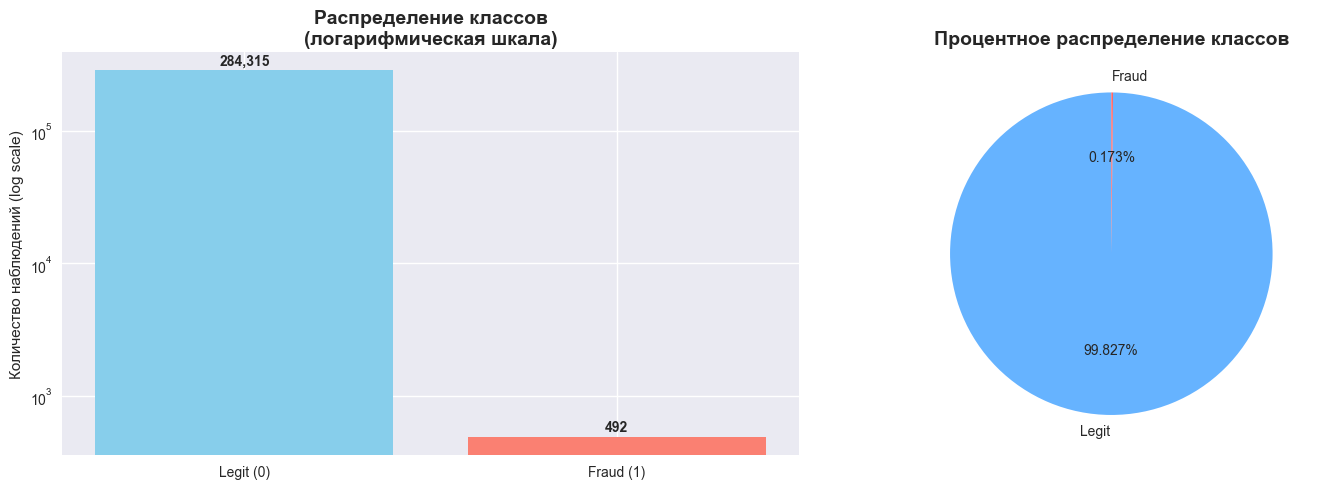

In [53]:
# Визуализация распределения классов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(['Legit (0)', 'Fraud (1)'], class_distribution.values, color=['skyblue', 'salmon'])
ax1.set_title('Распределение классов\n(логарифмическая шкала)', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.set_ylabel('Количество наблюдений (log scale)')

for i, v in enumerate(class_distribution.values):
    ax1.text(i, v * 1.1, f'{v:,}', ha='center', fontweight='bold')

# pie_plot
colors = ['#66b3ff', '#ff6666']
ax2.pie(class_distribution.values, labels=['Legit', 'Fraud'], autopct='%1.3f%%', 
        colors=colors, startangle=90)
ax2.set_title('Процентное распределение классов', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Проверка на пропущенные значения

In [54]:
# проверка на пропуски в данных
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Пропущенные значения': missing_data,
    'Процент пропусков': missing_percentage
})

missing_columns = missing_info[missing_info['Пропущенные значения'] > 0]
if len(missing_columns) > 0:
    print("Есть пропуски:")
    print(missing_columns)
else:
    print("пропусков нет")

пропусков нет


### 3. Обучение

In [55]:
# не делаем вообще никаких преобразований в данных, т.к. это baseline
features = [f'V{i}' for i in range(1, 29)] + ['Time', 'Amount']
X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

Инициализируем следующие модели: 
- Logistic Regression
- Random Forest 
- XGBoost

In [62]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('classifier', LogisticRegression(
            random_state=42,
            max_iter=1000
        ))
    ]),
    'RandomForest': Pipeline([
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    'XGBoost': Pipeline([
        ('classifier', xgb.XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        ))
    ])
}


####  Кросс-валидация моделей

Результаты 5-кратной стратифицированной кросс-валидации:

LogisticRegression:
  ROC-AUC:    0.9594 ± 0.0122
  Avg Precision: 0.7221 ± 0.0401

RandomForest:
  ROC-AUC:    0.9451 ± 0.0248
  Avg Precision: 0.8384 ± 0.0288

XGBoost:
  ROC-AUC:    0.8294 ± 0.2153
  Avg Precision: 0.6124 ± 0.3075



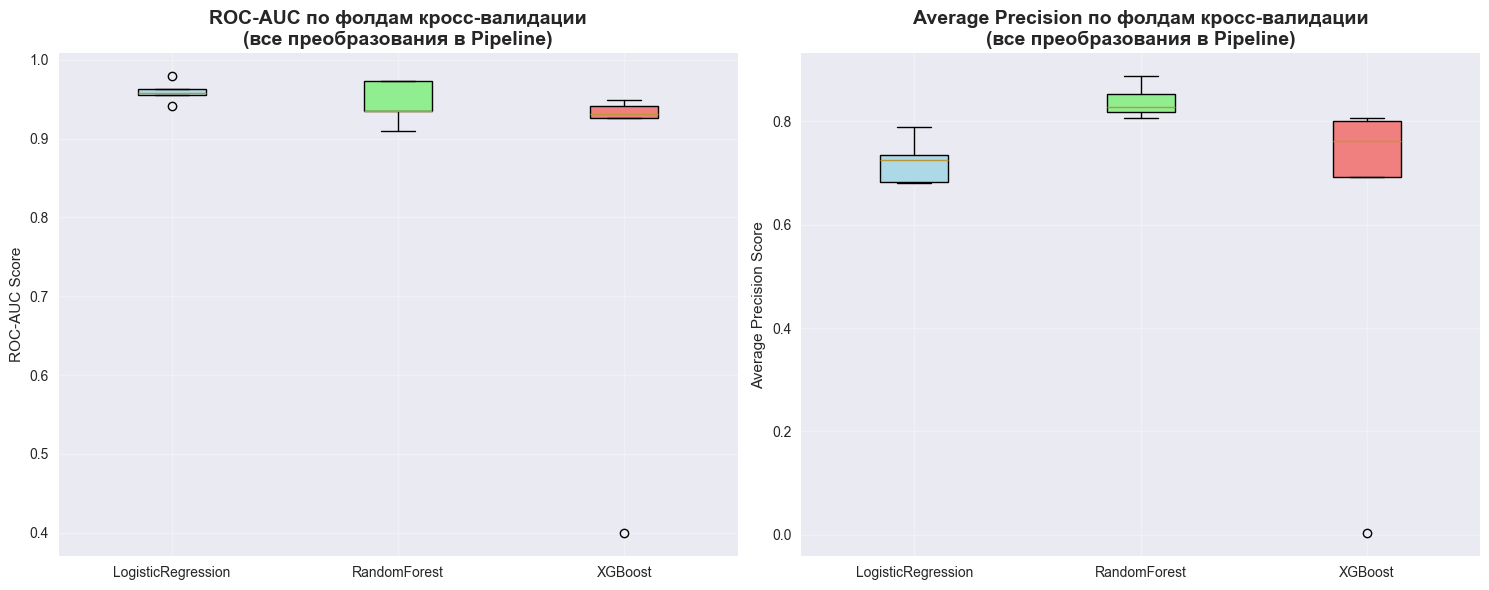

In [63]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("Результаты 5-кратной стратифицированной кросс-валидации:\n")

for model_name, pipeline in pipelines.items():
    cv_auc_scores = cross_val_score(pipeline, X_train, y_train, 
                                   cv=cv, scoring='roc_auc', n_jobs=-1)
    
    cv_ap_scores = cross_val_score(pipeline, X_train, y_train,
                                  cv=cv, scoring='average_precision', n_jobs=-1)
    
    cv_results[model_name] = {
        'roc_auc_mean': cv_auc_scores.mean(),
        'roc_auc_std': cv_auc_scores.std(),
        'avg_precision_mean': cv_ap_scores.mean(),
        'avg_precision_std': cv_ap_scores.std(),
        'cv_auc_scores': cv_auc_scores,
        'cv_ap_scores': cv_ap_scores
    }
    
    print(f"{model_name}:")
    print(f"  ROC-AUC:    {cv_auc_scores.mean():.4f} ± {cv_auc_scores.std():.4f}")
    print(f"  Avg Precision: {cv_ap_scores.mean():.4f} ± {cv_ap_scores.std():.4f}")
    print()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC-AUC 
auc_data = [cv_results[model]['cv_auc_scores'] for model in pipelines.keys()]
box1 = ax1.boxplot(auc_data, labels=pipelines.keys(), patch_artist=True)
ax1.set_title('ROC-AUC по фолдам кросс-валидации\n(все преобразования в Pipeline)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('ROC-AUC Score')
ax1.grid(True, alpha=0.3)

# AUPRC
ap_data = [cv_results[model]['cv_ap_scores'] for model in pipelines.keys()]
box2 = ax2.boxplot(ap_data, labels=pipelines.keys(), patch_artist=True)
ax2.set_title('Average Precision по фолдам кросс-валидации\n(все преобразования в Pipeline)', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Precision Score')
ax2.grid(True, alpha=0.3)

colors = ['lightblue', 'lightgreen', 'lightcoral']
for box, color in zip([box1, box2], [colors, colors]):
    for patch, col in zip(box['boxes'], color):
        patch.set_facecolor(col)

plt.tight_layout()
plt.show()


#### Обучение и оценка на тестовом наборе


--- Обучение LogisticRegression ---
ROC-AUC: 0.9569
Average Precision: 0.7015
Precision (Fraud): 0.8434
Recall (Fraud): 0.7143
F1-Score (Fraud): 0.7735

--- Обучение RandomForest ---
ROC-AUC: 0.9528
Average Precision: 0.8540
Precision (Fraud): 0.9524
Recall (Fraud): 0.8163
F1-Score (Fraud): 0.8791

--- Обучение XGBoost ---
ROC-AUC: 0.9390
Average Precision: 0.7973
Precision (Fraud): 0.8667
Recall (Fraud): 0.7959
F1-Score (Fraud): 0.8298


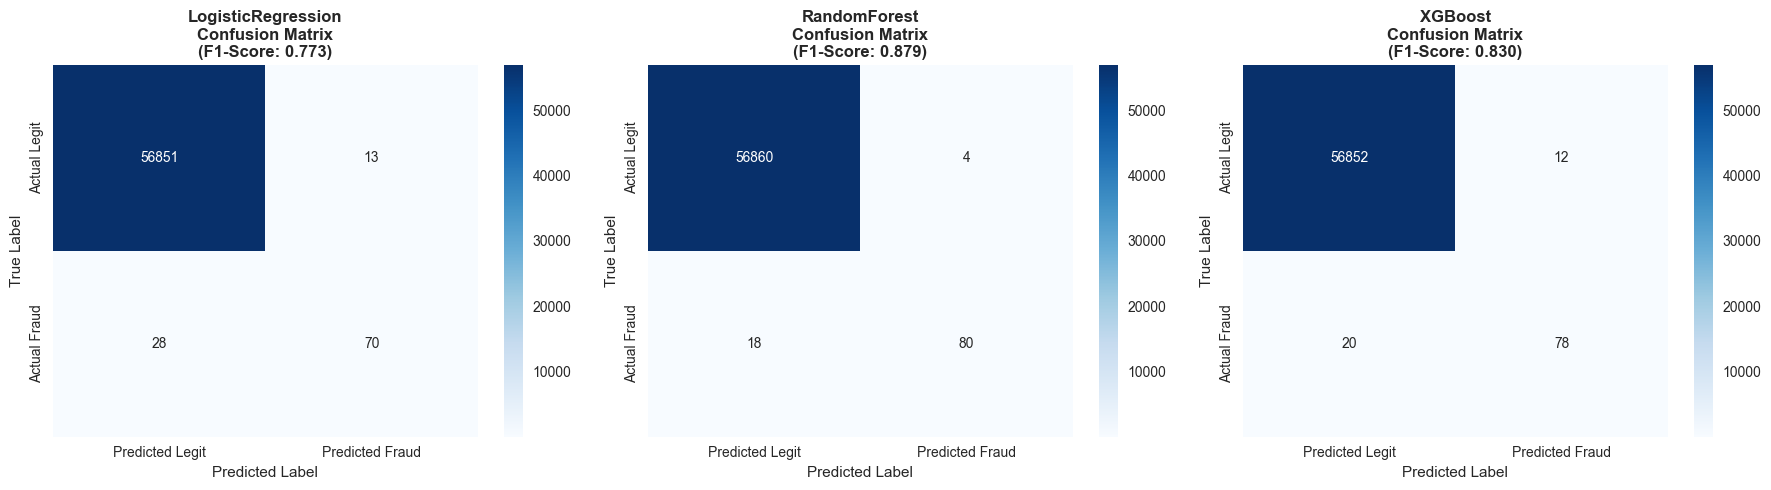

In [64]:
results = []
trained_pipelines = {}

# Создаем фигуру для матриц ошибок
fig, axes = plt.subplots(1, len(pipelines), figsize=(18, 5))
if len(pipelines) == 1:
    axes = [axes]

for idx, (model_name, pipeline) in enumerate(pipelines.items()):
    print(f"\n--- Обучение {model_name} ---")
    
    # Обучение Pipeline (включая все преобразования)
    pipeline.fit(X_train, y_train)
    trained_pipelines[model_name] = pipeline
    
    # Предсказания через Pipeline
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Метрики
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Детальная классификационная отчетность
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    # Сохранение результатов
    result = {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'average_precision': avg_precision,
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm
    }
    
    results.append(result)
    
    # Вывод результатов
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Precision (Fraud): {report['1']['precision']:.4f}")
    print(f"Recall (Fraud): {report['1']['recall']:.4f}")
    print(f"F1-Score (Fraud): {report['1']['f1-score']:.4f}")
    
    # Визуализация матрицы ошибок
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Predicted Legit', 'Predicted Fraud'],
                yticklabels=['Actual Legit', 'Actual Fraud'])
    axes[idx].set_title(f'{model_name}\nConfusion Matrix\n(F1-Score: {report["1"]["f1-score"]:.3f})', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Можем видеть, что лучший результат по целевой метрике(AveragePrecision/AUPRC) показывает RandomForest, ROC-AUC метрика у всех моделей высокая, но связано это с дисбалансом классов

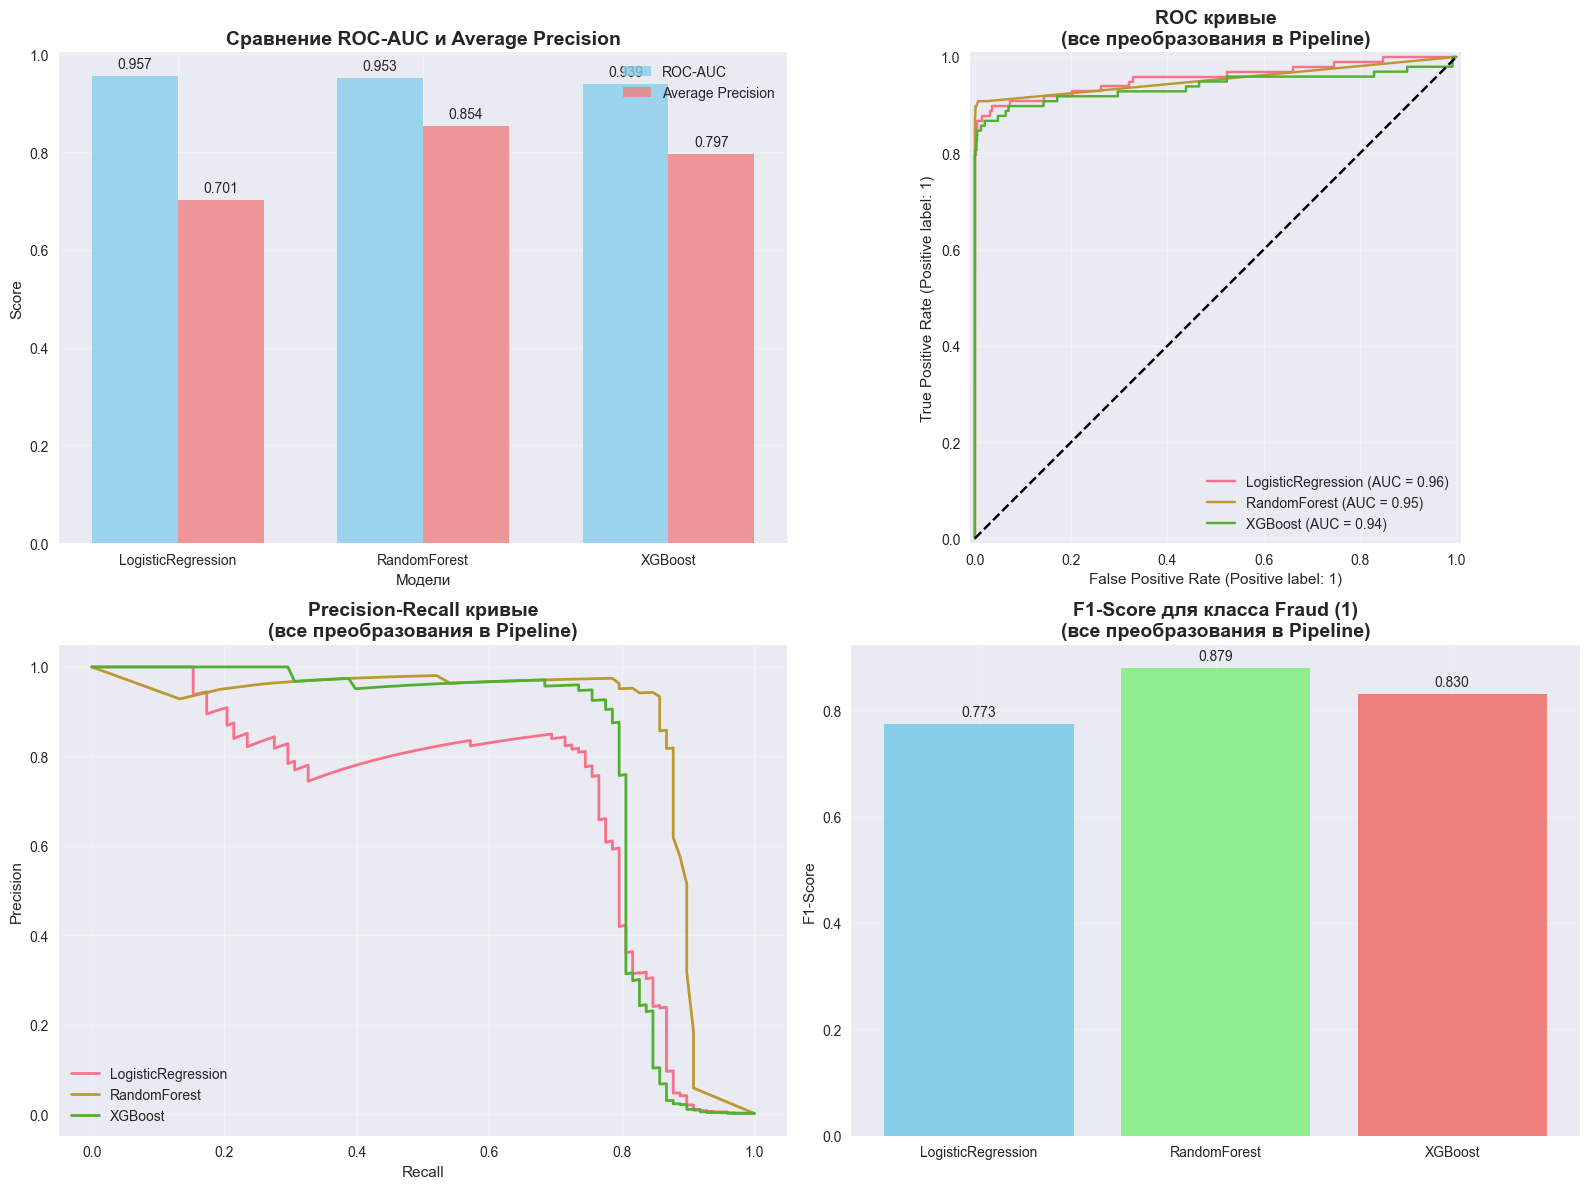

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

results_df = pd.DataFrame(results)
metrics_comparison = results_df[['model_name', 'roc_auc', 'average_precision']].set_index('model_name')

x = np.arange(len(metrics_comparison))
width = 0.35

ax1.bar(x - width/2, metrics_comparison['roc_auc'], width, label='ROC-AUC', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, metrics_comparison['average_precision'], width, label='Average Precision', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Модели')
ax1.set_ylabel('Score')
ax1.set_title('Сравнение ROC-AUC и Average Precision', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_comparison.index)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Добавление значений на столбцы
for i, v in enumerate(metrics_comparison['roc_auc']):
    ax1.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(metrics_comparison['average_precision']):
    ax1.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 2. ROC кривые
for result in results:
    RocCurveDisplay.from_predictions(
        y_test, result['y_pred_proba'],
        name=result['model_name'],
        ax=ax2
    )
ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax2.set_title('ROC кривые\n(все преобразования в Pipeline)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall кривые
for result in results:
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    ax3.plot(recall, precision, label=result['model_name'], linewidth=2)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall кривые\n(все преобразования в Pipeline)', 
              fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Сравнение F1-Score для класса 1 (Fraud)
f1_scores = [result['f1_1'] for result in results]
models_names = [result['model_name'] for result in results]

bars = ax4.bar(models_names, f1_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
ax4.set_ylabel('F1-Score')
ax4.set_title('F1-Score для класса Fraud (1)\n(все преобразования в Pipeline)', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Добавление значений на столбцы
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### FeatureImportance

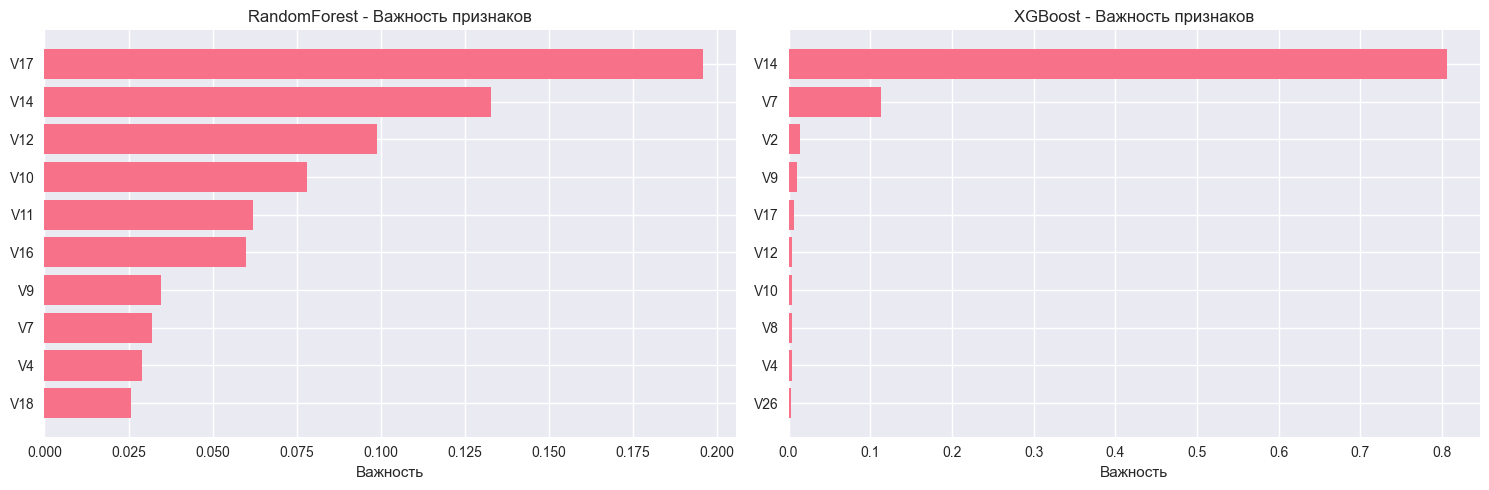

Итоговые результаты
            Модель  Average Precision
      RandomForest             0.8540
           XGBoost             0.7973
LogisticRegression             0.7015

Лучшая модель: RandomForest
Average Precision: 0.8540


In [45]:
feature_names = X_train.columns.tolist()

tree_pipelines = {name: pipeline for name, pipeline in trained_pipelines.items() 
                  if hasattr(pipeline.named_steps['classifier'], 'feature_importances_')}

if tree_pipelines:
    fig, axes = plt.subplots(1, len(tree_pipelines), figsize=(15, 5))
    if len(tree_pipelines) == 1:
        axes = [axes]
    
    for idx, (model_name, pipeline) in enumerate(tree_pipelines.items()):
        model = pipeline.named_steps['classifier']
        importances = model.feature_importances_
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=True).tail(10)
        
        bars = axes[idx].barh(importance_df['feature'], importance_df['importance'])
        axes[idx].set_title(f'{model_name} - Важность признаков')
        axes[idx].set_xlabel('Важность')
    
    plt.tight_layout()
    plt.show()

# Итоговые результаты
print("Итоговые результаты")

summary_df = pd.DataFrame(results)
summary_df = summary_df[['model_name', 'average_precision']].sort_values('average_precision', ascending=False)
summary_df.columns = ['Модель', 'Average Precision']

print(summary_df.to_string(index=False, float_format='%.4f'))

best_model = summary_df.iloc[0]
print(f"\nЛучшая модель: {best_model['Модель']}")
print(f"Average Precision: {best_model['Average Precision']:.4f}")

#### Вывод: 
По результатам Baseline пайплайна можно сделать вывод о том, что наилучшей моделью является RandomForest. Далее будут предприняты различные шаги по улучшению результата. 